In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_packets_path = "fixed-downlink/ap_all_packets.csv"
all_packets = pd.read_csv(all_packets_path)

In [3]:
filter_condition = all_packets["Protocol"] == "UDP"
udp_packets = all_packets[filter_condition == True]

In [4]:
print(len(udp_packets))

159199


In [5]:
print(udp_packets.head())

    No.     Time       Source  Destination Protocol  Length  Sequence number  \
15   16  0.40736  192.168.1.1  192.168.1.2      UDP    1524              0.0   
16   17  0.40736  192.168.1.1  192.168.1.2      UDP    1524              1.0   
17   18  0.40736  192.168.1.1  192.168.1.2      UDP    1524              2.0   
18   19  0.40736  192.168.1.1  192.168.1.2      UDP    1524              3.0   
19   20  0.40736  192.168.1.1  192.168.1.2      UDP    1524              4.0   

    MCS index  A-MPDU reference number                             Retry  
15        6.0                      0.0  Frame is not being retransmitted  
16        6.0                      0.0  Frame is not being retransmitted  
17        6.0                      0.0  Frame is not being retransmitted  
18        6.0                      0.0  Frame is not being retransmitted  
19        6.0                      0.0  Frame is not being retransmitted  


In [6]:
time = udp_packets["Time"]
sequence_numbers = udp_packets["Sequence number"]
retries = udp_packets["Retry"]
mcs_values = udp_packets["MCS index"]
data = udp_packets["Length"]
ampdu_ref = udp_packets["A-MPDU reference number"]

In [7]:
print(sequence_numbers.isna().sum())

0


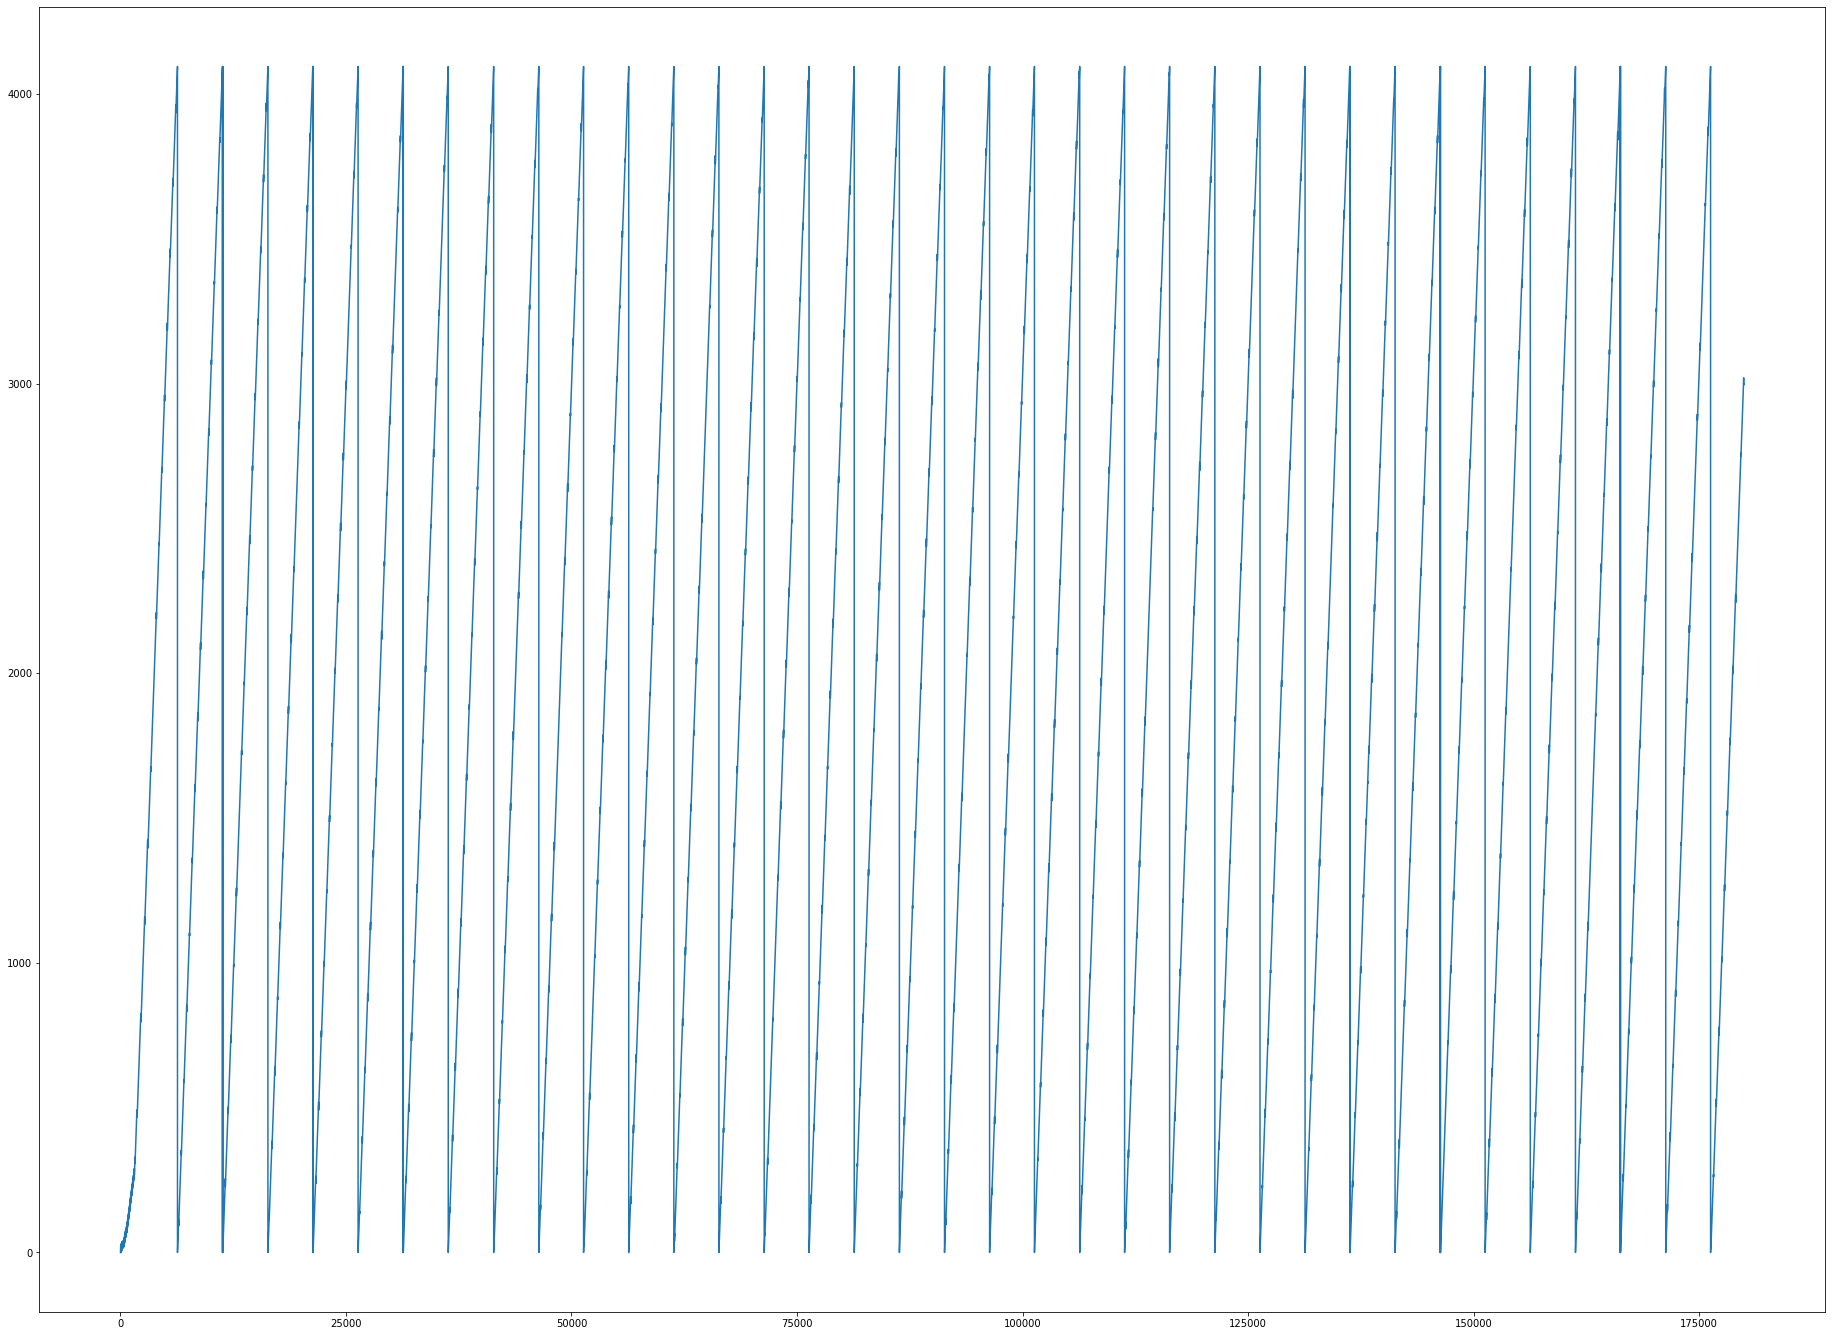

In [8]:
plt.figure(figsize=(32, 24))
plt.plot(sequence_numbers)
plt.show()

In [9]:
def unroll(seq_nums):
    max_seq_num = 4096
    transition_region = max_seq_num/4
    transition_threshold = max_seq_num/2
    counter = 0
    counter_hyst = 0
    new_seq_num = []
    
    for _, seq_num in seq_nums.items():
        if seq_num >= 0 and seq_num <= transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + counter*max_seq_num)
        elif seq_num > transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + (counter - 1)*max_seq_num)
        else:
            new_seq_num.append(seq_num + counter*max_seq_num)
            
        if seq_num == max_seq_num - 1 and counter_hyst == 0:
            counter += 1
            counter_hyst = 1
        elif counter_hyst > 0:
            counter_hyst += 1
        
        if counter_hyst >= transition_region:
            counter_hyst = 0
            
    udp_packets["New Sequence number"] = new_seq_num

In [10]:
unroll(sequence_numbers)

/home/EU/dedevarr/NS3-analysis/nsvenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
new_sequence_numbers = udp_packets["New Sequence number"]

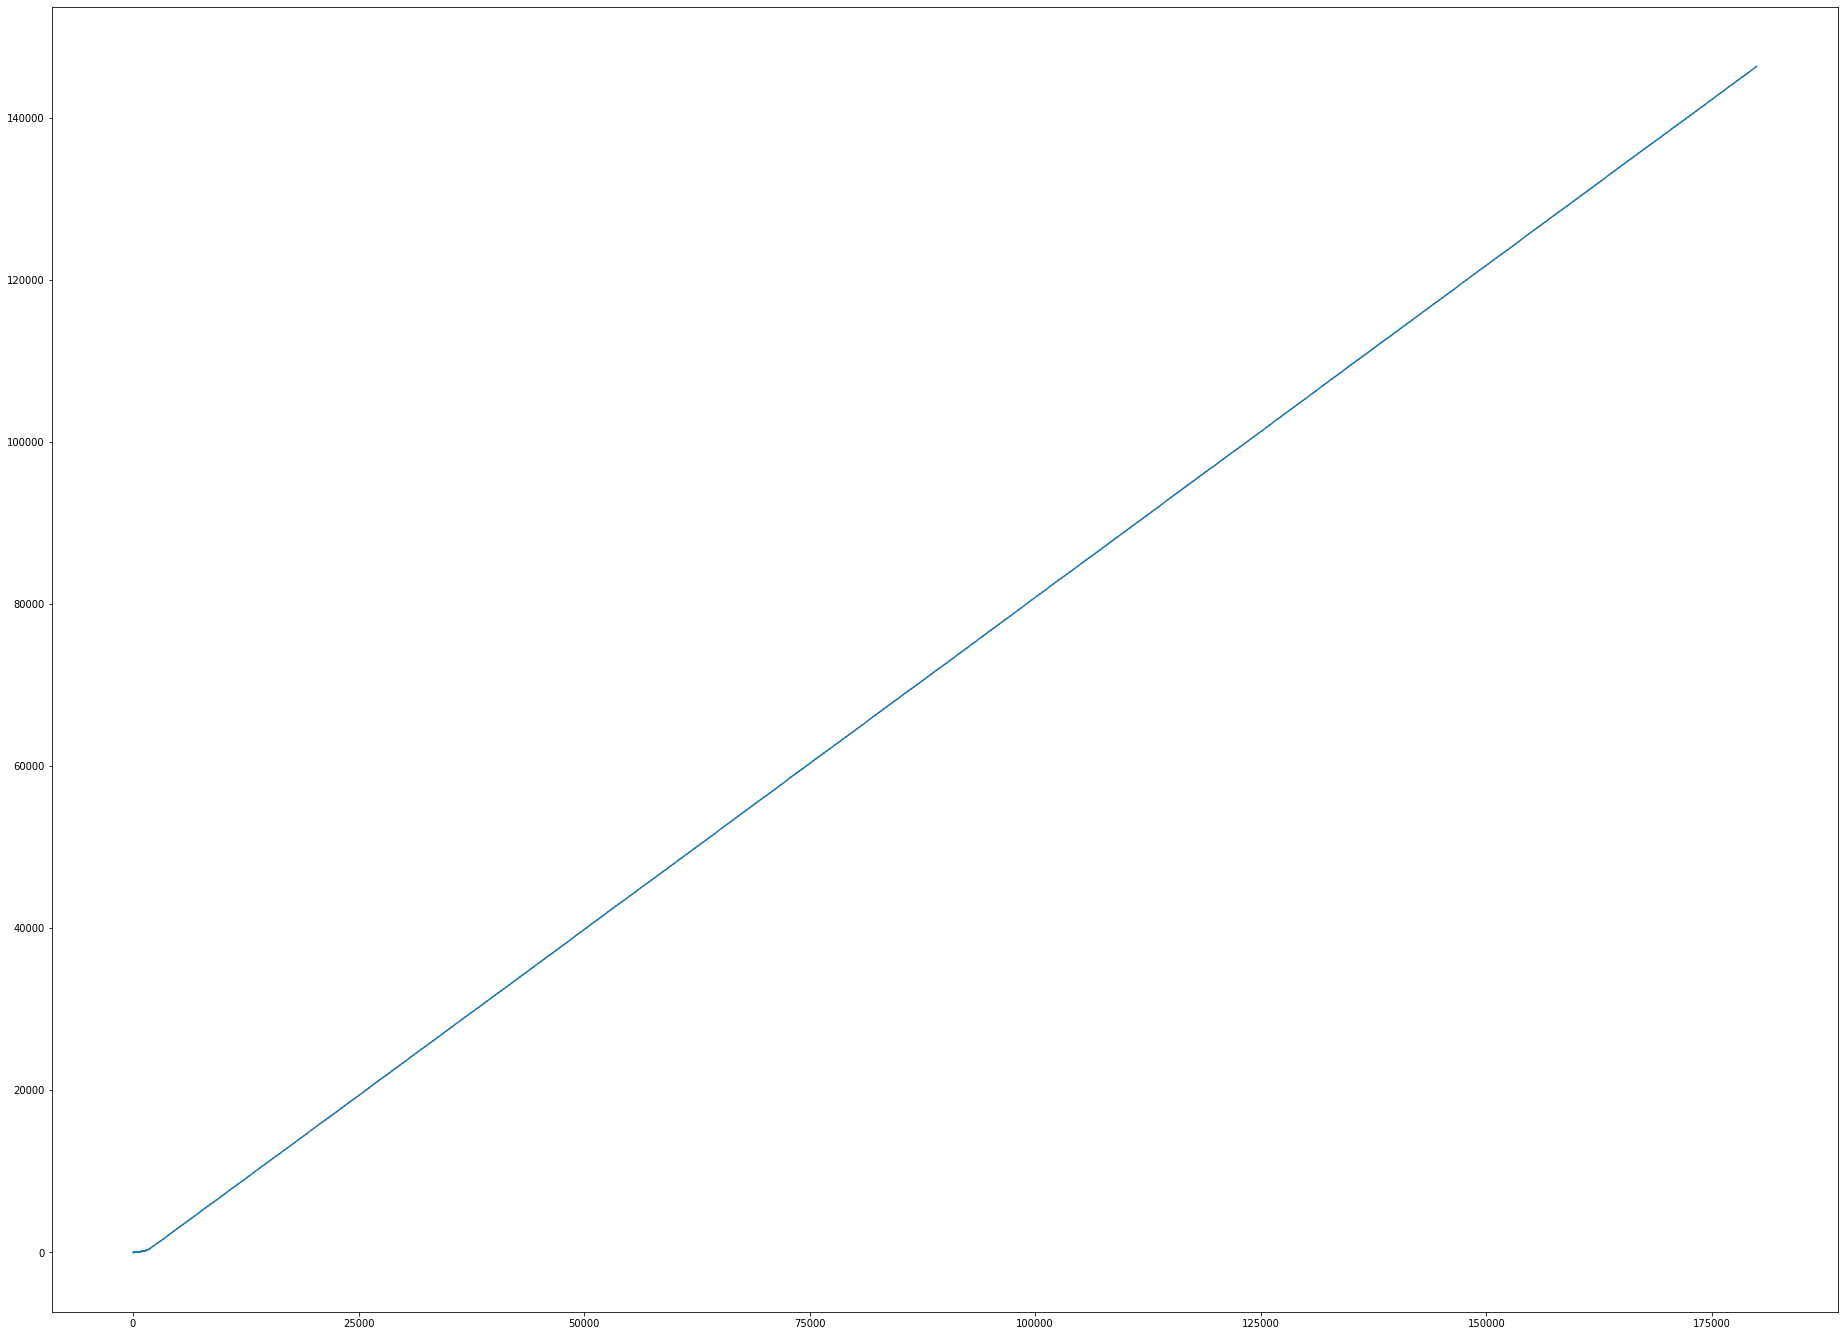

In [12]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers)
plt.show()

In [13]:
print(udp_packets.head())

    No.     Time       Source  Destination Protocol  Length  Sequence number  \
15   16  0.40736  192.168.1.1  192.168.1.2      UDP    1524              0.0   
16   17  0.40736  192.168.1.1  192.168.1.2      UDP    1524              1.0   
17   18  0.40736  192.168.1.1  192.168.1.2      UDP    1524              2.0   
18   19  0.40736  192.168.1.1  192.168.1.2      UDP    1524              3.0   
19   20  0.40736  192.168.1.1  192.168.1.2      UDP    1524              4.0   

    MCS index  A-MPDU reference number                             Retry  \
15        6.0                      0.0  Frame is not being retransmitted   
16        6.0                      0.0  Frame is not being retransmitted   
17        6.0                      0.0  Frame is not being retransmitted   
18        6.0                      0.0  Frame is not being retransmitted   
19        6.0                      0.0  Frame is not being retransmitted   

    New Sequence number  
15                  0.0  
16        

In [14]:
num_retries = np.zeros(len(udp_packets))

In [15]:
for i in range(0, len(udp_packets)):
    unique_sequence_number = int(new_sequence_numbers.iloc[i])
    if retries.iloc[i] == "Frame is being retransmitted":
        num_retries[unique_sequence_number] += 1

In [16]:
print(num_retries.min())
print(num_retries.max())

0.0
13.0


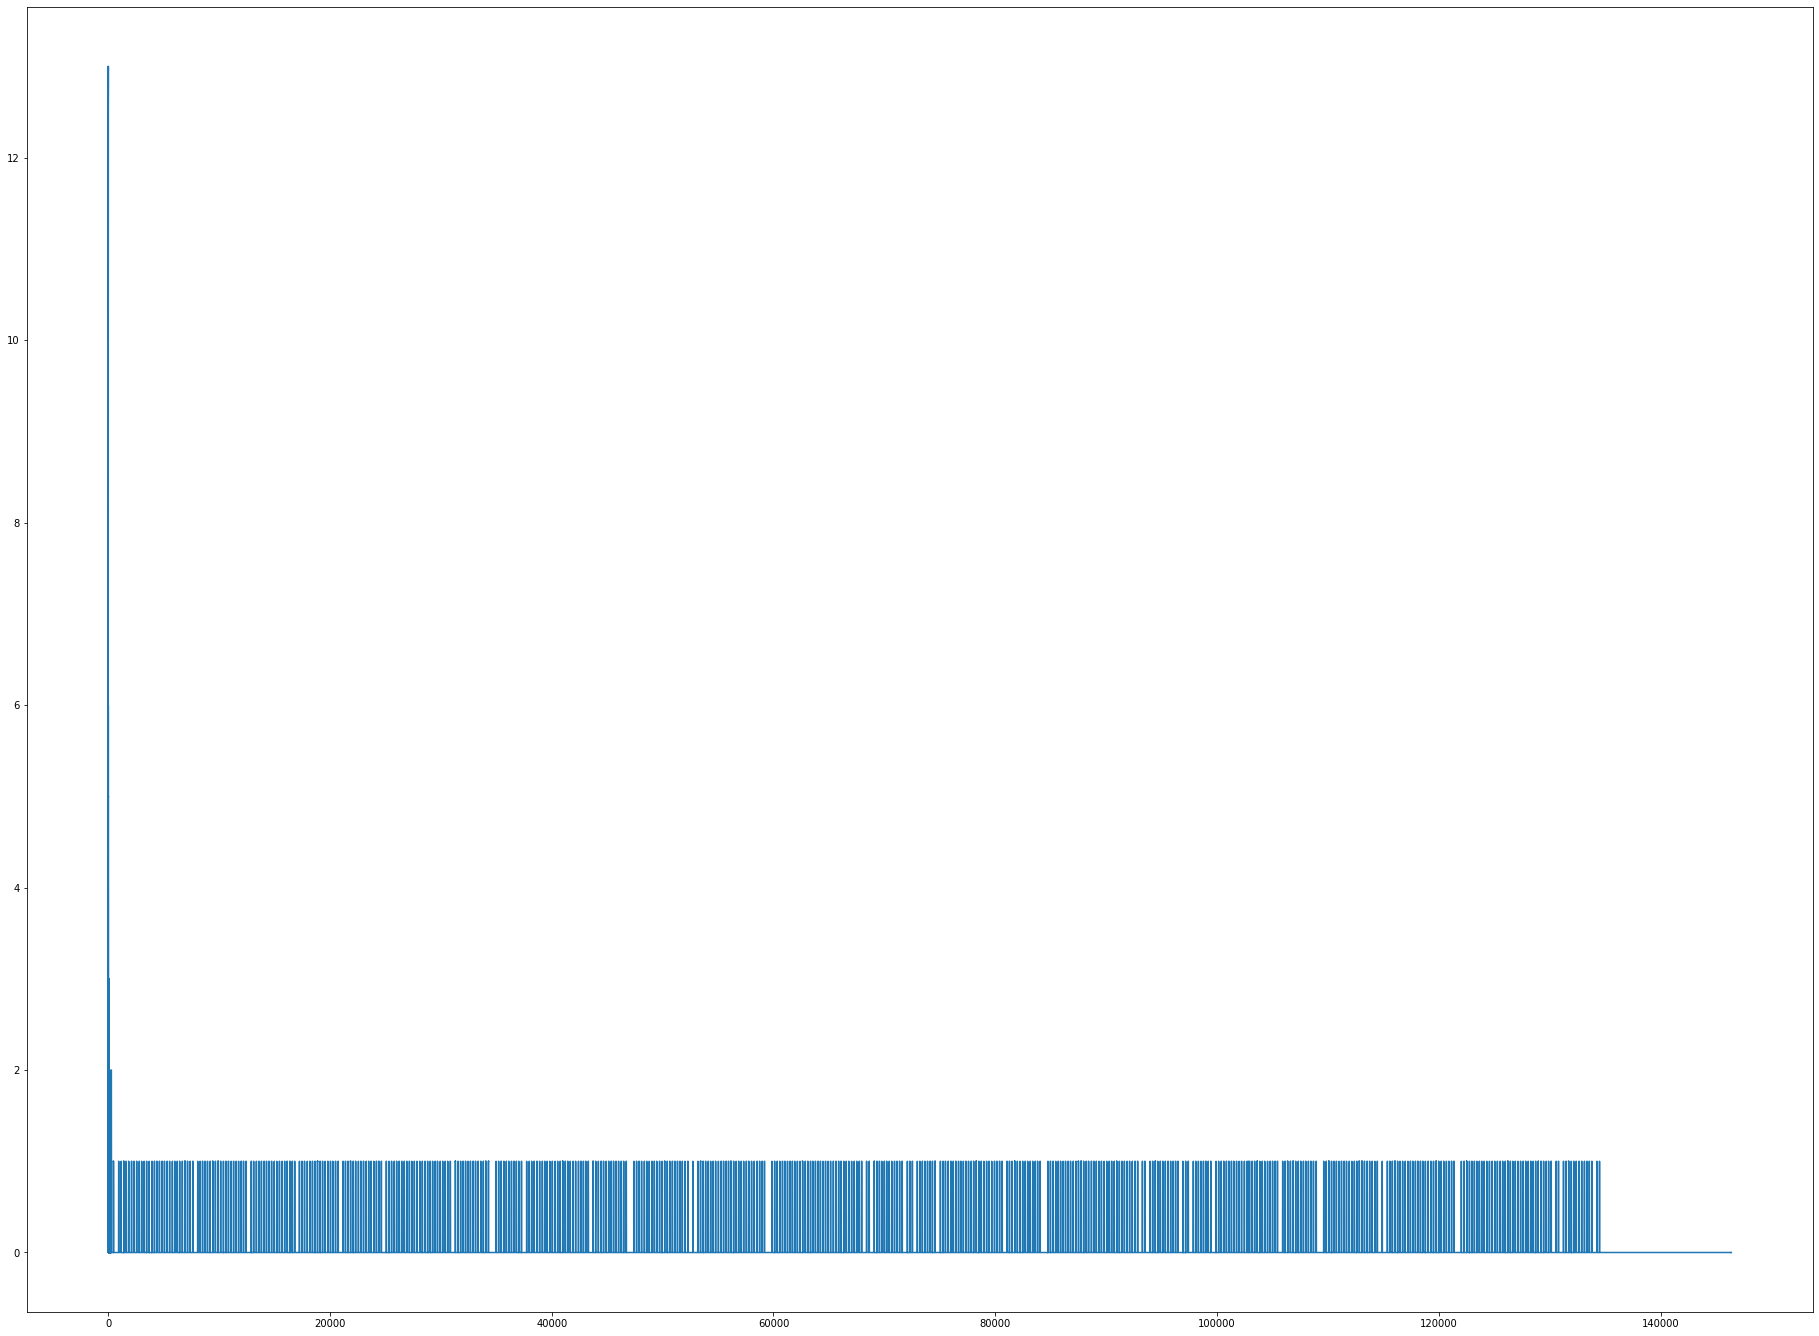

In [17]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers, num_retries)
plt.show()

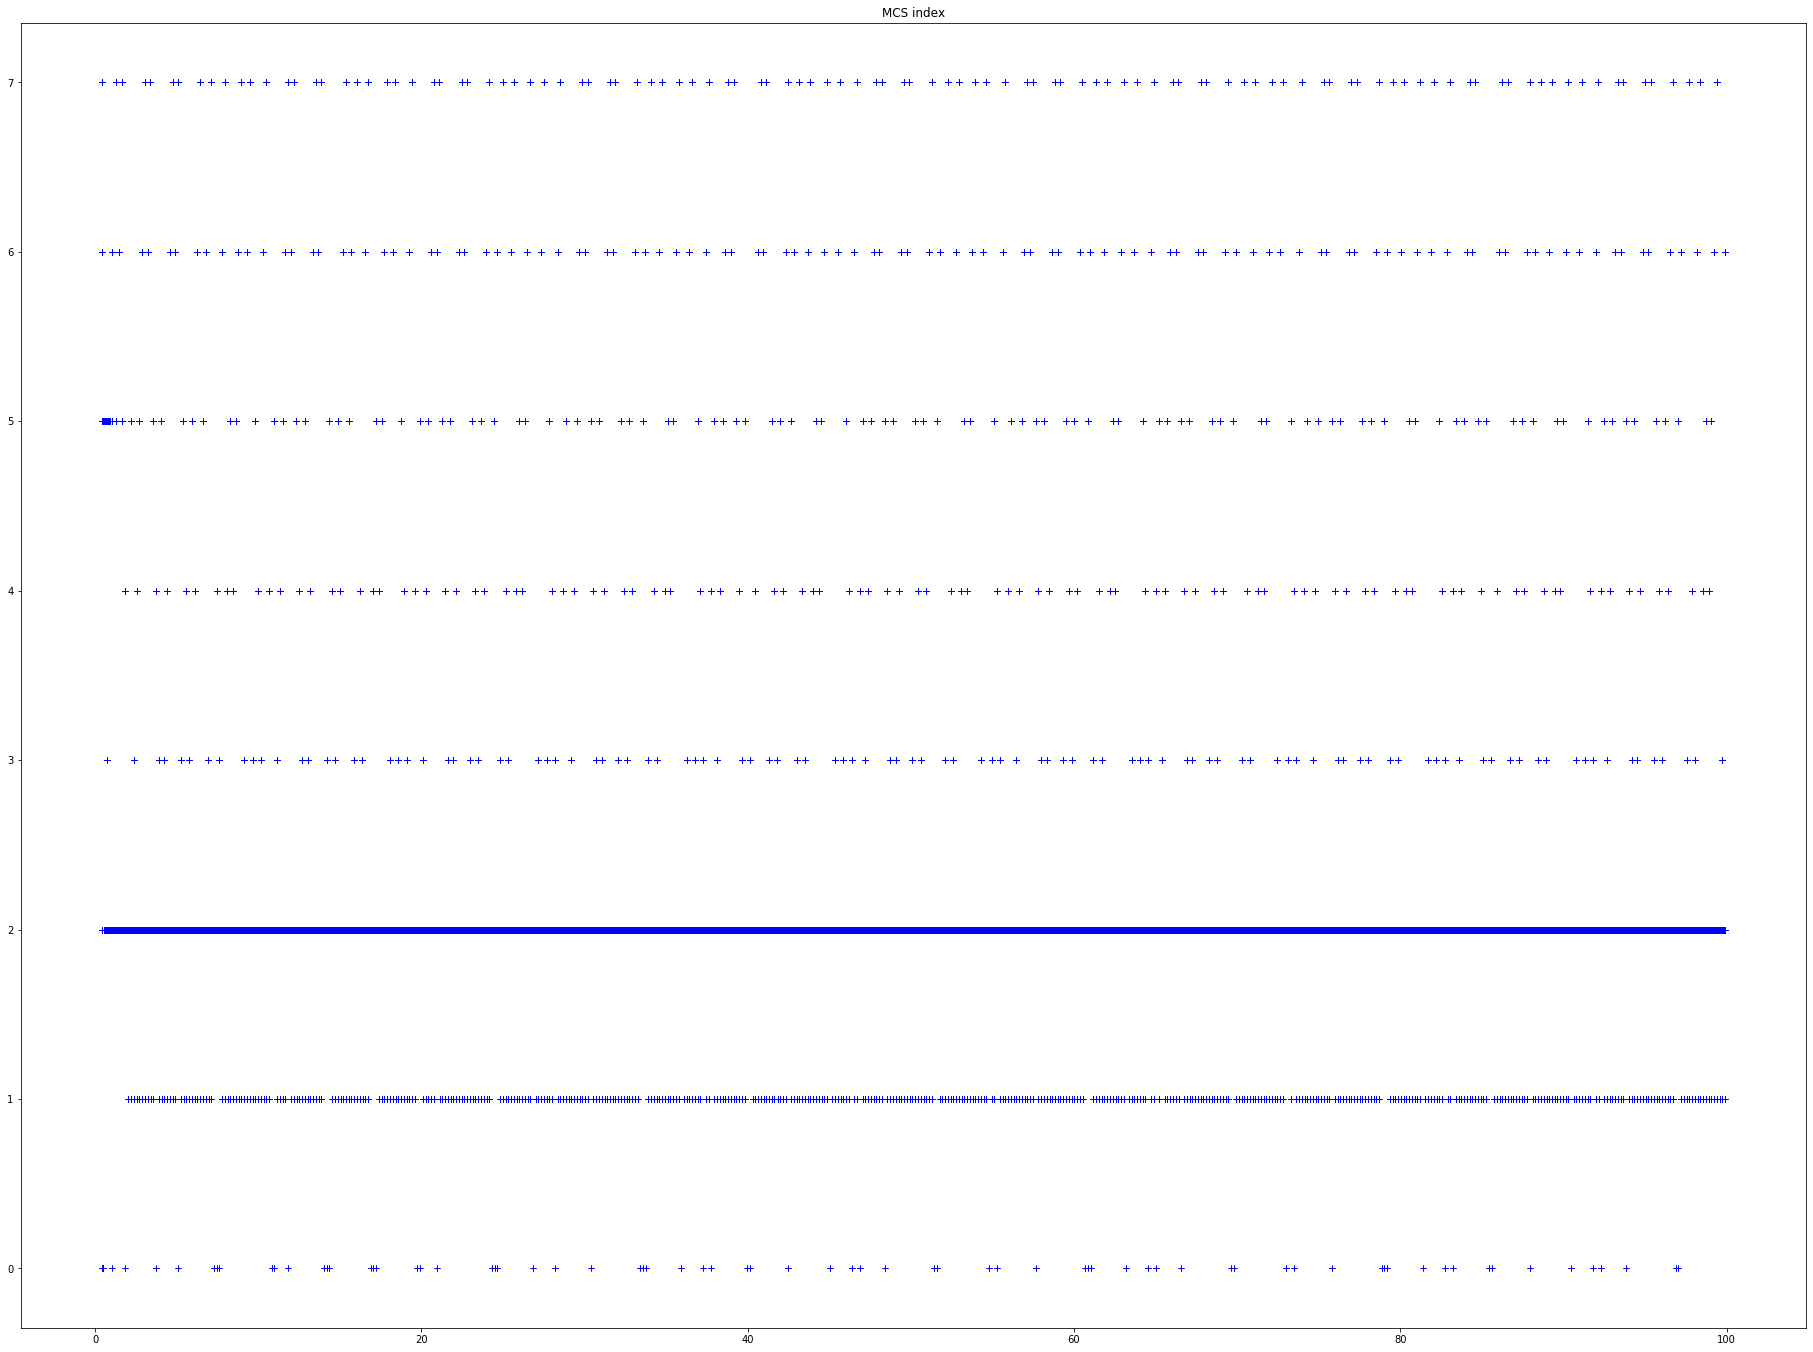

In [18]:
plt.figure(figsize=(32, 24))
plt.title("MCS index")
plt.plot(time, mcs_values, 'b+')
plt.show()

In [19]:
start_time = time.iloc[0]
print(start_time)

0.40736


In [20]:
throughput_values = []

curr_time = start_time
i = 0

while i < len(udp_packets):
    total_bytes = 0
    while i < len(udp_packets) and time.iloc[i] < curr_time + 1.0:
        total_bytes += data.iloc[i]
        i += 1
    throughput_values.append(total_bytes)
    curr_time = time.iloc[i-1]

In [21]:
print(len(throughput_values))
throughput = np.asarray(throughput_values)

100


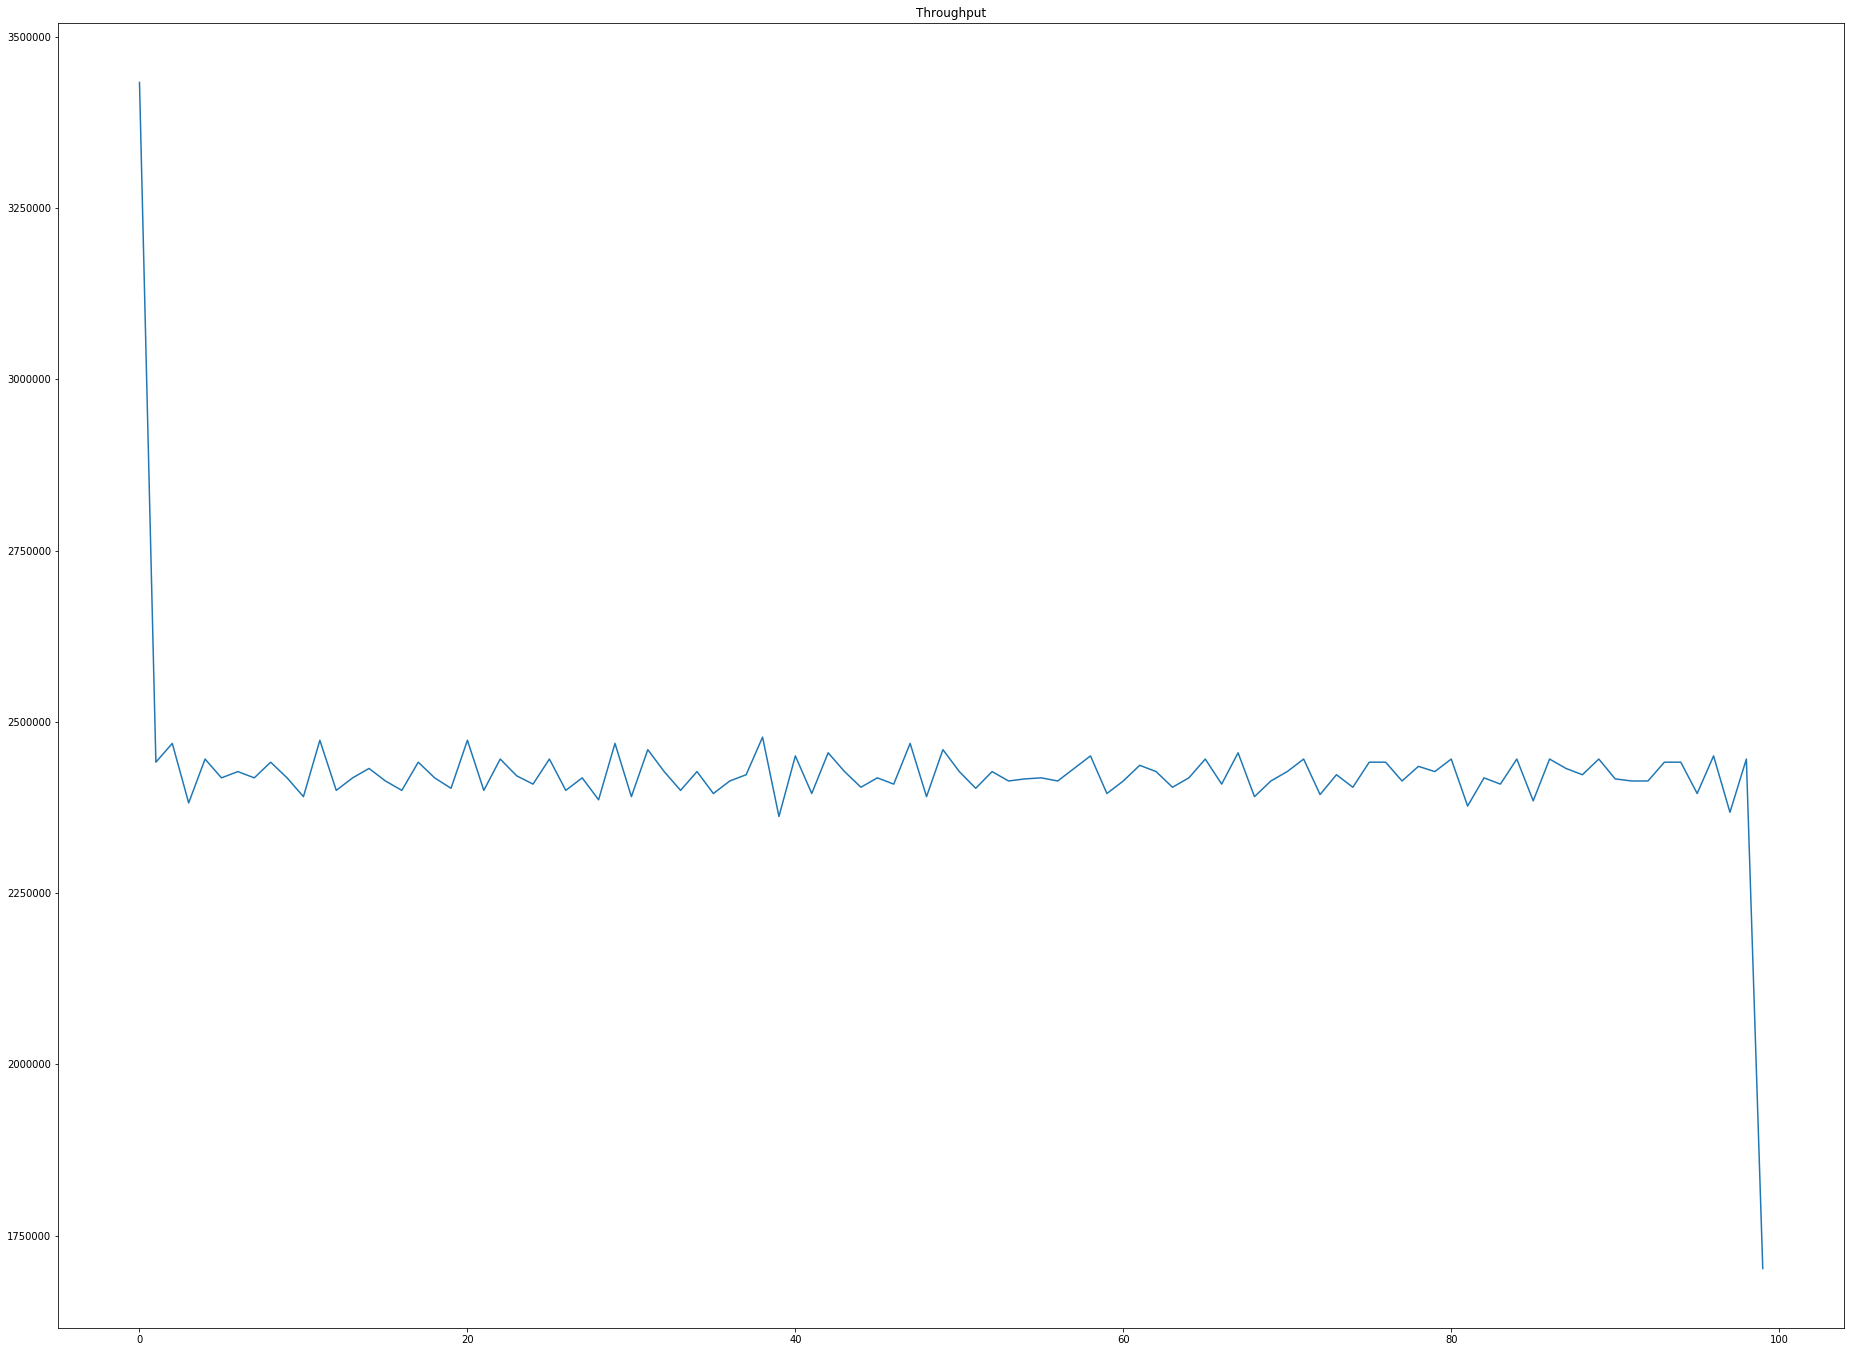

In [22]:
plt.figure(figsize=(32, 24))
plt.title("Throughput")
plt.plot(throughput)
plt.show()

In [23]:
print(ampdu_ref.isna().sum())

0


In [24]:
offset = 0
for i in range(0, len(ampdu_ref)):
    if np.isnan(ampdu_ref.iloc[i]):
        offset += 1
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i-1]) + 1
    else:
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i]) + offset

In [25]:
print(ampdu_ref.isna().sum())

0


In [26]:
print(ampdu_ref.tail())

179933    19141.0
179934    19141.0
179935    19141.0
179936    19141.0
179937    19141.0
Name: A-MPDU reference number, dtype: float64


In [27]:
last_ampdu_ref = int(udp_packets.iloc[len(udp_packets) - 1]["A-MPDU reference number"])
print(last_ampdu_ref)
time_index = np.zeros(last_ampdu_ref + 1)
ampdu_sizes = np.zeros(last_ampdu_ref + 1)

for i in range(0, len(udp_packets)):
    current_ampdu_ref = int(ampdu_ref.iloc[i])
    if time_index[current_ampdu_ref] == 0:
        time_index[current_ampdu_ref] = time.iloc[i]
    if current_ampdu_ref >= 0:
        ampdu_sizes[current_ampdu_ref] += 1

19141


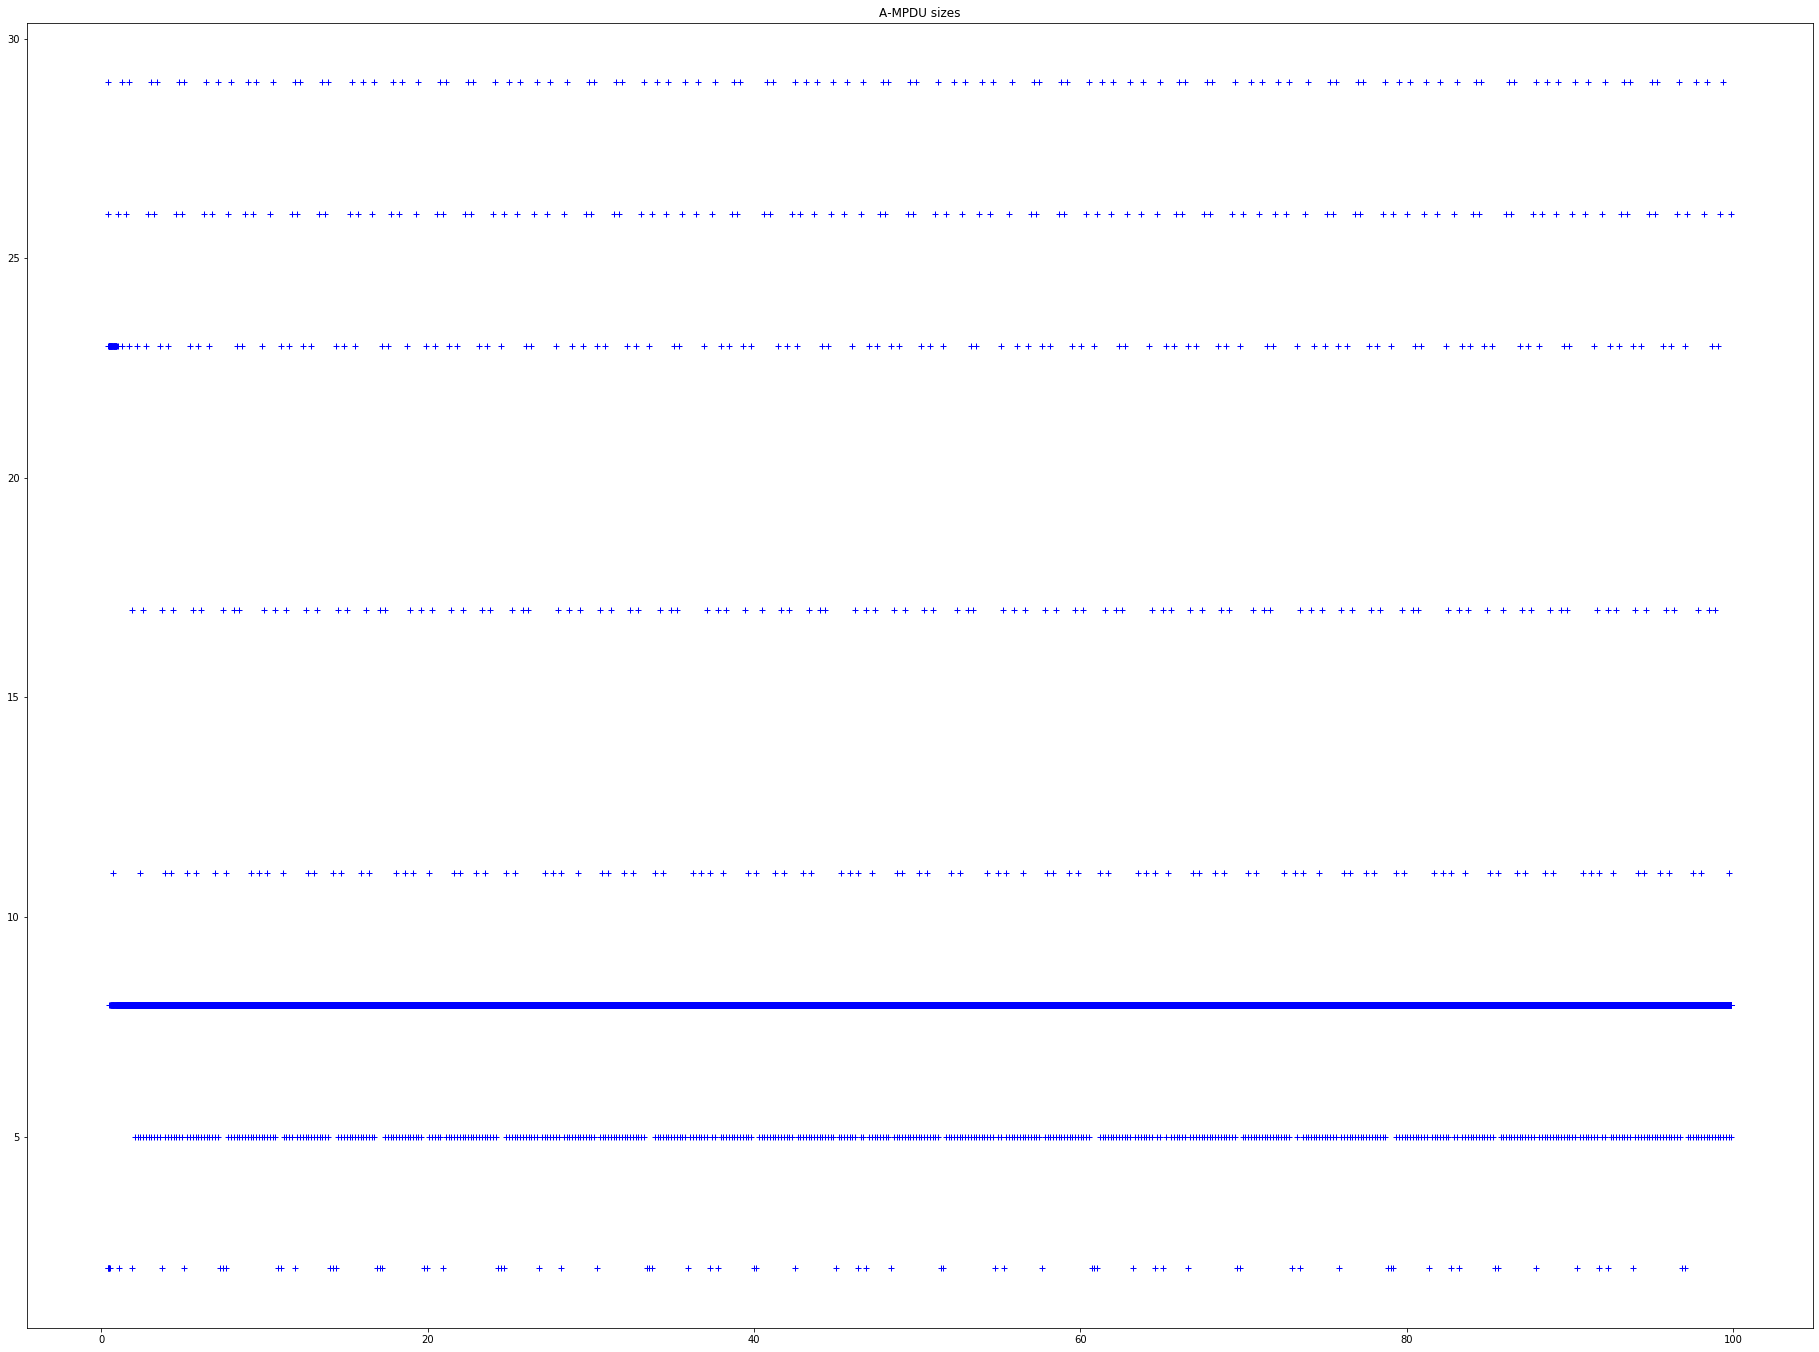

In [28]:
plt.figure(figsize=(32, 24))
plt.title("A-MPDU sizes")
plt.plot(time_index, ampdu_sizes, 'b+')
plt.show()

In [29]:
file = open('fixed-downlink/retry_information.txt', 'w')

for seq_number in range(0, len(new_sequence_numbers)):
    if num_retries[seq_number] > 0:
        file.write("This sequence number tries more than once: {}\n".format(seq_number))
        file.write("Information about all tries:\n")
        all_data = udp_packets[udp_packets["New Sequence number"] == seq_number]
        my_time = all_data["Time"]
        my_mcs = all_data["MCS index"]
        my_ampdu_ref = all_data["A-MPDU reference number"]
        for i in range(0, len(all_data)):
            file.write("Retry: {}\n".format(i+1))
            file.write("Time: {}\n".format(my_time.iloc[i]))
            file.write("MCS: {}\n".format(my_mcs.iloc[i]))
            file.write("A-MPDU size: {}\n".format(ampdu_sizes[int(my_ampdu_ref.iloc[i])]))

file.close()